In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from scipy.sparse import *
import stop_words
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer

%matplotlib inline

In [39]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## RegExp crash course

https://regex101.com

https://regexr.com

In [40]:
match = re.fullmatch(r'\d\d\D\d\d', r'12-12') 
print('YES' if match else 'NO') 

YES


In [41]:
match = re.fullmatch(r'\d\d\D\d\d', r'Т. 12-12') 
print('YES' if match else 'NO') 

NO


In [42]:
print(re.split(r'\W+', 'Где, скажите мне, мои очки??!')) 

['Где', 'скажите', 'мне', 'мои', 'очки', '']


In [43]:
print(re.findall(r'\d\d\.\d\d\.\d{4}', 
                 r'Эта строка написана 21.01.2019, а могла бы и 01.09.2017')) 

['21.01.2019', '01.09.2017']


In [44]:
print(re.sub(r'\d\d\.\d\d\.\d{4}', 
             r'DD.MM.YYYY', 
             r'Эта строка написана 21.01.2019, а могла бы и 01.09.2017')) 

Эта строка написана DD.MM.YYYY, а могла бы и DD.MM.YYYY


In [45]:
re.findall(r'\w+$', 'AV is largest Analytics community of India')

['India']

In [46]:
re.findall(r'\w\w', 'AV is largest Analytics community of India')

['AV',
 'is',
 'la',
 'rg',
 'es',
 'An',
 'al',
 'yt',
 'ic',
 'co',
 'mm',
 'un',
 'it',
 'of',
 'In',
 'di']

In [47]:
re.findall(r'@\w+', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['@gmail', '@test', '@analyticsvidhya', '@rest']

In [48]:
re.findall(r'@\w+.\w+', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['@gmail.com', '@test.in', '@analyticsvidhya.com', '@rest.biz']

In [49]:
re.findall(r'@\w+.(\w+)', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['com', 'in', 'com', 'biz']

In [50]:
re.findall(r'[aeiouAEIOU]\w+', 'AV is largest Analytics community of India')

['AV', 'is', 'argest', 'Analytics', 'ommunity', 'of', 'India']

In [51]:
re.findall(r'\d([A-Z][A-Za-z]+)([A-Z][A-Za-z]+)', 
          '1NoahEmma2LiamOlivia3MasonSophia4JacobIsabella5WilliamAva6EthanMia7MichaelEmily')

[('Noah', 'Emma'),
 ('Liam', 'Olivia'),
 ('Mason', 'Sophia'),
 ('Jacob', 'Isabella'),
 ('William', 'Ava'),
 ('Ethan', 'Mia'),
 ('Michael', 'Emily')]

# Обработка реального текста

In [52]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

In [53]:
GRAMMS = ['NOUN', 'ADJF', 'ADJS', 'PRTF', 'PRTS', 'GRND', 'ADVB']

[**Data**](http://study.mokoron.com/)

---

In [54]:
DATA_PATH = 'go_V.csv'

In [55]:
df = pd.read_csv(DATA_PATH, sep=';')
print(df.shape)
df = df[:1000]

(1000, 2)


In [56]:
df.head()

,text,topic
0,Ученые выяснили что водные и околоводные птицы...,Наука и техника
1,Пресс-атташе казахстанского футбольного клуба ...,Спорт
2,Бывший футболист «Спартака» и сборной СССР Але...,Спорт
3,В ближайшие дни состоится встреча нефтедобываю...,Экономика
4,Физики из Массачусетского технологического инс...,Наука и техника


In [57]:
df

,text,topic
0,Ученые выяснили что водные и околоводные птицы...,Наука и техника
1,Пресс-атташе казахстанского футбольного клуба ...,Спорт
2,Бывший футболист «Спартака» и сборной СССР Але...,Спорт
3,В ближайшие дни состоится встреча нефтедобываю...,Экономика
4,Физики из Массачусетского технологического инс...,Наука и техника
5,Ежедневное употребление около 09 литра кофе (п...,Наука и техника
6,«Барселона» после победы в матче 27-го тура ч...,Спорт
7,Ученые из колледжа Королевы Марии Лондонского ...,Наука и техника
8,Банк России отозвал с 4 марта 2016 года лиценз...,Экономика
9,"""Американский актер Кристиан Бэйл признался чт...",Культура


In [58]:
df.text

0      Ученые выяснили что водные и околоводные птицы...
1      Пресс-атташе казахстанского футбольного клуба ...
2      Бывший футболист «Спартака» и сборной СССР Але...
3      В ближайшие дни состоится встреча нефтедобываю...
4      Физики из Массачусетского технологического инс...
5      Ежедневное употребление около 09 литра кофе (п...
6      «Барселона» после победы в матче  27-го тура ч...
7      Ученые из колледжа Королевы Марии Лондонского ...
8      Банк России отозвал с 4 марта 2016 года лиценз...
9      "Американский актер Кристиан Бэйл признался чт...
10     Бывший футболист сборной России Александр Мост...
11     Нападающий «Флориды Пантерс» Яромир Ягр в матч...
12     Банк России отозвал лицензию у «Страховой инве...
13     Британский актер Саша Барон Коэн рассказал что...
14     Курс доллара при открытии торгов на Московской...
15     Интернет-портал «Чемпионат.com» объявил о запу...
16     Научный журнал PLoS One опубликовал креационис...
17     Игроки футбольного клуба

---

In [59]:
corpus, texts = [], []

for message in log_progress(df.text.dropna().as_matrix()):
    sp = message.split('\n')
    corpus += sp
    texts += sp
#     break

CORPUS = corpus

print(len(corpus), len(texts))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


999 999


In [64]:
print (corpus[0])

Ученые выяснили что водные и околоводные птицы в болотах Флориды специально строят гнезда поблизости от аллигаторов. Рептилии выполняют функции телохранителей отпугивая от птиц других хищников — зато расплачиваются с ними пернатые своими птенцами выпадающими из гнезд. Об этом открытии сообщается в журнале PLoS One. Для цапель аистов ибисов и колпиц Флориды наибольшую опасность представляют хищники-млекопитающие (еноты и опоссумы) — они разоряют гнезда и убивают птенцов. По этой причине птицы предпочитают гнездиться неподалеку от аллигаторов. Зоологи захотели выяснить что такое соседство дает рептилиям и приносит ли оно им выгоду. Они сравнили массу тела 40 самок аллигаторов живущих рядом с птицами в болотах Эверглейдс — и в отдалении от пернатых. Ученые брали анализ крови и измеряли массу и длину пресмыкающихся. Оказалось что жизнь рядом с гнездами птиц делает аллигаторов примерно на 15-20 процентов упитаннее. Дело в том что птицы «платят» своим защитникам дань лишними птенцами: околов

**Уберем ссылки:**

In [65]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', doc) for doc in corpus]
corpus = [re.sub(' +' , ' ', doc) for doc in corpus]
print(len(corpus))

999


**Уберем лишние пробелы:**

In [66]:
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'') for doc in corpus])
print(len(corpus))

999


**Уберем другие лишние символы:**

In [67]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [69]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
print(len(corpus))

999


In [70]:
corpus = [regex_dig.sub('', doc) for doc in corpus]
print(len(corpus))

999


In [71]:
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
print(len(corpus))

999


In [72]:
corpus = [regex_struct.sub('', doc) for doc in corpus]
print(len(corpus))

999


In [73]:
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]
print(len(corpus))

999


In [74]:
texts = np.asarray([txt for doc, txt in zip(corpus, texts) if len(doc) > 0])
print(len(texts))
corpus = np.asarray([doc for doc in corpus if len(doc) > 0])
CORPUS = np.asarray([doc for doc in CORPUS if len(doc) > 0])
print(len(corpus))

999
999


In [75]:
corpus = [doc.lower() for doc in corpus]
print(len(corpus))

999


In [76]:
corpus = [emoji_pattern.sub('', doc) for doc in corpus]
print(len(corpus))

999


In [77]:
morph = pymorphy2.MorphAnalyzer()

In [78]:
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(log_progress(corpus[:])):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
#     break
        
print(len(corpus_tokens), len(texts))

999 999


In [79]:
print(len(texts))
texts = [t for i, t in enumerate(texts) if i not in inds_to_drop]
print(len(texts))

999
999


In [80]:
stemmer = RussianStemmer()

*см. также  **лемамтизацию** в [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/user/guide.html#normalization) и [nltk](https://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#nltk.stem.wordnet.WordNetLemmatizer)*

In [81]:
corpus_tokens_stem = []

for i, tokens in enumerate(log_progress(corpus_tokens[:])):
    tmp = [stemmer.stem(word) for word in tokens]
    corpus_tokens_stem.append(tmp)
#     break
    
print(len(corpus_tokens_stem))

999


In [82]:
corpus_tokens[100]

['марта',
 'началось',
 'извержение',
 'вулкана',
 'эквадоре',
 'подземные',
 'толчки',
 'наблюдались',
 'районе',
 'горы',
 'февраля',
 'началу',
 'марта',
 'ситуация',
 'ухудшилась',
 'вулкана',
 'постоянно',
 'вылетают',
 'газы',
 'пепел',
 'столб',
 'пепла',
 'жерлом',
 'вытянулся',
 'тысячи',
 'метров',
 'власти',
 'страны',
 'объявили',
 'оранжевый',
 'уровень',
 'опасности',
 'располагается',
 'километрах',
 'югу',
 'столицы',
 'страны',
 'кито',
 'высота',
 'метра',
 'уровнем',
 'моря',
 'название',
 'вулкана',
 'переводе',
 'кечуа',
 'означает',
 'огненное',
 'горло',
 'активным']

In [83]:
corpus_tokens_stem[100]

['март',
 'нача',
 'извержен',
 'вулка',
 'эквадор',
 'подземн',
 'толчк',
 'наблюда',
 'район',
 'гор',
 'феврал',
 'начал',
 'март',
 'ситуац',
 'ухудш',
 'вулка',
 'постоя',
 'вылета',
 'газ',
 'пепел',
 'столб',
 'пепл',
 'жерл',
 'вытянул',
 'тысяч',
 'метр',
 'власт',
 'стран',
 'объяв',
 'оранжев',
 'уровен',
 'опасн',
 'располага',
 'километр',
 'юг',
 'столиц',
 'стран',
 'кит',
 'высот',
 'метр',
 'уровн',
 'мор',
 'назван',
 'вулка',
 'перевод',
 'кечу',
 'означа',
 'огнен',
 'горл',
 'активн']

---

In [84]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

999 999


In [85]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

999


(0, 30)

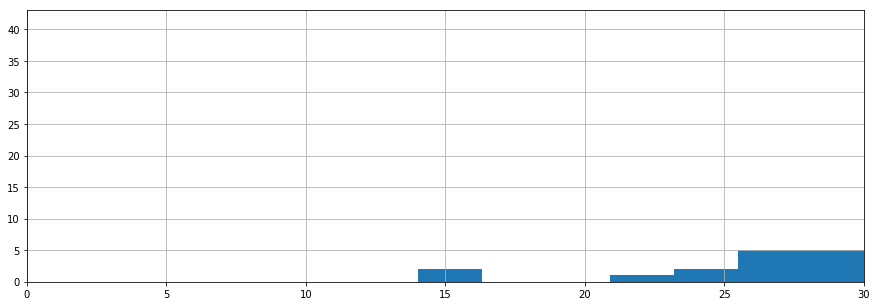

In [86]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 30)

In [87]:
corpus_tokens_stem[diffs == 2]

array([], dtype=object)

In [88]:
np.unique(corpus_tokens_stem).shape[0] / float(corpus_tokens_stem.shape[0])

1.0

In [89]:
stat = {}

tmp_corp, tmp_texts = [], []

for i, tokens in enumerate(log_progress(corpus_tokens_stem)):
    s = ' '.join(tokens)
    if stat.get(s, None) is None:
        stat[s] = True
        tmp_corp.append(tokens)
        tmp_texts.append(texts[i])
        
corpus_tokens_stem = tmp_corp
texts = tmp_texts
print(len(corpus_tokens_stem), len(texts))

999 999


In [90]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

999 999


In [91]:
corpus_tokens_stem[0]

['учен',
 'выясн',
 'водн',
 'околоводн',
 'птиц',
 'болот',
 'флорид',
 'специальн',
 'стро',
 'гнезд',
 'поблиз',
 'аллигатор',
 'рептил',
 'выполня',
 'функц',
 'телохранител',
 'отпугив',
 'птиц',
 'хищник',
 'расплачива',
 'пернат',
 'сво',
 'птенц',
 'выпада',
 'гнезд',
 'открыт',
 'сообща',
 'журнал',
 'цапел',
 'аист',
 'ибис',
 'колпиц',
 'флорид',
 'наибольш',
 'опасн',
 'представля',
 'енот',
 'опоссум',
 'разоря',
 'гнезд',
 'убива',
 'птенц',
 'причин',
 'птиц',
 'предпочита',
 'гнезд',
 'неподалек',
 'аллигатор',
 'зоолог',
 'захотел',
 'выясн',
 'соседств',
 'дает',
 'рептил',
 'принос',
 'выгод',
 'сравн',
 'масс',
 'тел',
 'самок',
 'аллигатор',
 'живущ',
 'птиц',
 'болот',
 'отдален',
 'пернат',
 'учен',
 'брал',
 'анализ',
 'кров',
 'измеря',
 'масс',
 'длин',
 'пресмыка',
 'оказа',
 'гнезд',
 'птиц',
 'дела',
 'аллигатор',
 'примерн',
 'упита',
 'дел',
 'птиц',
 'плат',
 'сво',
 'защитник',
 'дан',
 'лишн',
 'птенц',
 'околоводн',
 'птиц',
 'откладыва',
 'яиц',
 'вы

In [1326]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

1009


(0, 10)

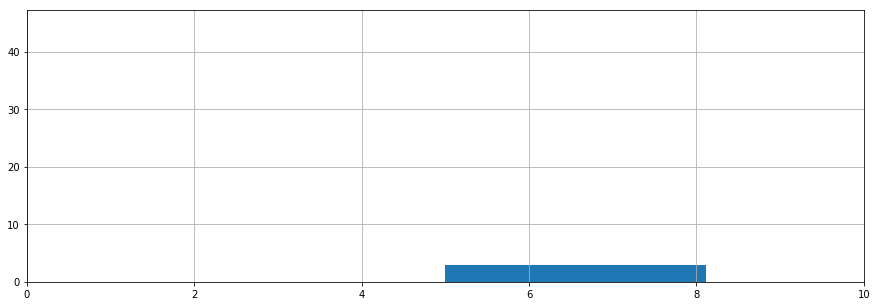

In [1327]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 10)

In [1328]:
corpus_tokens_stem[diffs == 7]

array([], dtype=object)

In [1329]:
corpus_tokens_stem[diffs >= 8].shape

(1007,)

In [1330]:
corp4learning = corpus_tokens_stem[diffs >= 8]
texts4learning = texts[diffs >= 8]

In [1331]:
tmp_corp = []

for tokens in corp4learning:
    tmp_corp.append([t for t in tokens if len(t) > 2])
corp4learning = tmp_corp

In [1332]:
vocab = np.unique(np.concatenate(corp4learning).flatten()).tolist()
print(len(vocab))

12706


In [1333]:
corpus_tokens_stem

array([list(['учен', 'выясн', 'водн', 'околоводн', 'птиц', 'болот', 'флорид', 'специальн', 'стро', 'гнезд', 'поблиз', 'аллигатор', 'рептил', 'выполня', 'функц', 'телохранител', 'отпугив', 'птиц', 'хищник', 'расплачива', 'пернат', 'сво', 'птенц', 'выпада', 'гнезд', 'открыт', 'сообща', 'журнал', 'цапел', 'аист', 'ибис', 'колпиц', 'флорид', 'наибольш', 'опасн', 'представля', 'енот', 'опоссум', 'разоря', 'гнезд', 'убива', 'птенц', 'причин', 'птиц', 'предпочита', 'гнезд', 'неподалек', 'аллигатор', 'зоолог', 'захотел', 'выясн', 'соседств', 'дает', 'рептил', 'принос', 'выгод', 'сравн', 'масс', 'тел', 'самок', 'аллигатор', 'живущ', 'птиц', 'болот', 'отдален', 'пернат', 'учен', 'брал', 'анализ', 'кров', 'измеря', 'масс', 'длин', 'пресмыка', 'оказа', 'гнезд', 'птиц', 'дела', 'аллигатор', 'примерн', 'упита', 'дел', 'птиц', 'плат', 'сво', 'защитник', 'дан', 'лишн', 'птенц', 'околоводн', 'птиц', 'откладыва', 'яиц', 'выраст', 'птенц', 'выкидыва', 'лишн', 'гнезд', 'аллигатор', 'извлека', 'выгод', 'пт

In [1334]:
with open('словарь.txt', 'w') as f:
    for item in vocab:
        f.write(item + '\n')

In [1335]:
print (len(corpus_tokens_stem))
print (len(df))

1009
1000


In [1336]:
corpus_tokens_stem1 = corpus_tokens_stem
for i in range(len(corpus_tokens_stem1)):
    corpus_tokens_stem1[i] = ' '.join(corpus_tokens_stem1[i])

In [1337]:
corpuus = pd.DataFrame(corpus_tokens_stem1)

In [1338]:
corpuus.to_csv("corpuus.csv", sep=';', index=False, header=None)

In [1339]:
u = {}
for word in vocab:
    u[word]=[]
    for i in range(len(corpus_tokens_stem)):
        if (' ' + word + ' ') in corpus_tokens_stem[i]:
            u[word].append(i)

In [1340]:
u

{'абака': [443],
 'абакан': [],
 'абдел': [652],
 'абдурахма': [260],
 'абдурахмон': [114],
 'абонент': [641, 882],
 'абонентск': [121],
 'абрамов': [85],
 'абрамович': [127, 279],
 'абрикос': [95],
 'абсолютн': [154, 206, 348, 403, 410, 424, 869, 941, 963, 965, 989],
 'абсурд': [972],
 'абсурдн': [436],
 'авангард': [172],
 'авангардист': [503],
 'авантюр': [13],
 'авар': [94,
  219,
  274,
  306,
  334,
  347,
  443,
  585,
  609,
  616,
  643,
  716,
  819,
  837,
  865,
  875,
  930],
 'аварийн': [90,
  159,
  275,
  308,
  327,
  334,
  348,
  422,
  456,
  457,
  529,
  585,
  694,
  865,
  880,
  906,
  914],
 'аватар': [360],
 'август': [11,
  19,
  66,
  95,
  124,
  135,
  143,
  150,
  168,
  211,
  215,
  220,
  224,
  225,
  226,
  238,
  279,
  293,
  310,
  317,
  324,
  328,
  333,
  362,
  366,
  387,
  429,
  462,
  477,
  484,
  489,
  532,
  604,
  615,
  630,
  635,
  671,
  709,
  749,
  761,
  766,
  770,
  776,
  796,
  806,
  846,
  961,
  982],
 'авиабаз': [38

In [1351]:
s = "как оформить визу в америку"

In [1352]:
l = s.split(' ')
newl = []
for i in range(len(l)):
    l[i] = stemmer.stem(l[i])
    if (l[i] in vocab):
        newl.append(l[i])
print (newl)

['как', 'оформ', 'виз', 'америк']


In [1353]:
res = {}
for word in newl:
    if word not in stop_words.get_stop_words('ru'):
        for num in u[word]:
            if (not num in res.keys()):
                res[num]=[1,[word]]
            else:
                res[num][0]+=1
                res[num][1].append(word)
print (res)

{103: [1, ['оформ']], 128: [1, ['оформ']], 157: [1, ['оформ']], 179: [2, ['оформ', 'америк']], 236: [1, ['оформ']], 441: [1, ['оформ']], 598: [1, ['оформ']], 601: [1, ['оформ']], 867: [1, ['оформ']], 938: [1, ['оформ']], 40: [1, ['виз']], 176: [1, ['виз']], 185: [1, ['виз']], 235: [1, ['виз']], 375: [1, ['виз']], 412: [1, ['виз']], 480: [1, ['виз']], 491: [1, ['виз']], 589: [2, ['виз', 'америк']], 667: [1, ['виз']], 800: [1, ['виз']], 13: [1, ['америк']], 102: [1, ['америк']], 139: [1, ['америк']], 216: [1, ['америк']], 227: [1, ['америк']], 253: [1, ['америк']], 416: [1, ['америк']], 463: [1, ['америк']], 510: [1, ['америк']], 523: [1, ['америк']], 586: [1, ['америк']], 593: [1, ['америк']], 798: [1, ['америк']], 854: [1, ['америк']], 861: [1, ['америк']], 866: [1, ['америк']], 888: [1, ['америк']], 1006: [1, ['америк']]}


In [1354]:
pupa = sorted(res.items(), key=lambda kv: kv[1], reverse=True)

In [1355]:
pupich = pupa[0:5]

In [1356]:
ss = []
for lupich in pupich:
    ss.append ([CORPUS[lupich[0]],lupich[1][1]])

In [1357]:
ss

[['Американский медиамагнат Руперт Мердок женился на бывшей модели Джерри Холл, которая младше его на 25 лет. Бракосочетание состоялось в пятницу, 4 марта, в Лондоне, сообщает Yahoo News. Церемония прошла в особняке XVIII века Спенсер-хаус. Предположительно, в субботу молодожены обвенчаются в церкви. 84-летний Мердок вступил в брак в четвертый раз. До Холл он был женат на Венди Денг — они сыграли свадьбу менее чем через три недели после второго развода бизнесмена. К настоящему времени от всех жен у Мердока есть шестеро детей. Для 59-летней Холл брак с Мердоком первый. Около 20 лет она встречалась с Миком Джаггером — вокалистом группы The Rolling Stones. В 1990 году на Бали они оформили отношения, однако союз был признан в Великобритании незаконным. Рассталась пара в 1999 году. У них четверо общих детей. До Джаггера у нее также были отношения с фронтменом группы Roxy Music Брайаном Ферри. Состояние Мердока, который возглавляет News Corp., оценивается в 11,6 миллиарда долларов. Его семья